# *(Wong & Wang, 2006)* Decision making rate model

In [1]:
import brainpy as bp

bp.math.set_dt(dt=0.0005)

## A rate model for decision-making

Consider two excitatory neural assemblies, populations $1$ and $2$, that compete with each other through a shared pool of 
inhibitory neurons.

![](../images/decision_model.png)


Let $r_1$ and $r_2$ be their respective population-firing rates, and the total synaptic input current $I_i$ and the resulting firing rate $r_i$ of the neural population $i$ obey the following input-output relationship ($F - I$ curve):

$$
r_i = F(I_i) = \frac{aI_i - b}{1-\exp(-d(aI_i-b))}
$$

which captures the current-frequency function of a leaky integrate-and-fire neuron. The parameter values are $a$ = 270 Hz/nA, $b$ = 108 Hz, $d$ = 0.154 sec.

Assume that the 'synaptic drive variables' $S_1$ and $S_2$ obey

\begin{align}
\frac{dS_1}{dt} &= F(I_1)\,\gamma(1-S_1)-S_1/\tau_s\\
\frac{dS_2}{dt} &= F(I_2)\,\gamma(1-S_2)-S_2/\tau_s
\end{align}

where $\gamma$ = 0.641. The net current into each population is given by 

\begin{align}
I_1 &= J_E S_1 + J_I S_2 + I_{b1} + J_{ext}\mu_1\\
I_2 &= J_E S_2 + J_I S_1 +I_{b2} +J_{ext}\mu_2.
\end{align}


The synaptic time constant is $\tau_s$ = 100 ms (NMDA time consant). The synaptic coupling strengths are $J_E$ = 0.2609 nA, $J_I$ = -0.0497 nA, and $J_{ext}$ = 0.00052 nA. Stimulus-selective inputs to populations 1 and 2 are governed by unitless parameters $\mu_1$ and $\mu_2$, respectively. $I_b$ is the background input which has a mean $I_0$ and a noise component described by an Ornstein-Uhlenbeck process:

\begin{align}
dI_{b1} &= (I_0 - I_{b1}) \frac{dt}{\tau_0} + \sigma dW \\
dI_{b2} &= (I_0 - I_{b2}) \frac{dt}{\tau_0} + \sigma dW \\
\end{align}

where $I_0=0.3255$ nA, filter time constant $\tau_0=2$ ms, and noise amplitude $\sigma=0.02$ nA. $dW$ is a Wiener process and note that when numerially integrating that with step size $\frac{dt}{\tau_0}$ then $\Delta W \sim \mathcal{N}(0, \frac{dt}{\tau_0})$, a normal distribution with mean 0 and variance $\frac{dt}{\tau_0}$

For the decision-making paradigm, the input rates $\mu_1$ and $\mu_2$ are determined by the stimulus coherence $c'$ which ranges between 0 (0%) and 1 (100%):

\begin{align}
\mu_1 &=\mu_0(1+c')\\
\mu_2 &=\mu_0(1-c')
\end{align}

**References:**

- Wong K-F and Wang X-J (2006). A recurrent network mechanism for time integration in perceptual decisions. J. Neurosci 26, 1314-1328.

## Implementation

In [2]:
gamma = 0.641  # Saturation factor for gating variable
tau = 0.06  # Synaptic time constant [sec]
tau0 = 0.002  # Noise time constant [sec]
a = 270.
b = 108.
d = 0.154

I0 = 0.3255  # background current [nA]
JE = 0.3725  # self-coupling strength [nA]
JI = -0.1137  # cross-coupling strength [nA]
JAext = 0.00117  # Stimulus input strength [nA]
sigma = 1.02  # nA


# I0 = 0.3255 # background current [nA]
# JE = 0.2609  # self-coupling strength [nA]
# JI = -0.0497  # cross-coupling strength [nA]
# JAext = 5.2e-4  # Stimulus input strength [nA]
# sigma = 0.02 # nA

In [3]:
class DecisionMaking(bp.NeuGroup):
  @staticmethod
  def current2rate(I):
    return (a * I - b) / (1. - bp.math.exp(-d * (a * I - b)))

  @staticmethod
  @bp.odeint
  def integral(s1, s2, t, mu0, coh, Ib1, Ib2):
    I1 = JE * s1 + JI * s2 + Ib1 + JAext * mu0 * (1. + coh)
    r1 = (a * I1 - b) / (1. - bp.math.exp(-d * (a * I1 - b)))
    ds1dt = - s1 / tau + (1. - s1) * gamma * r1

    I2 = JE * s2 + JI * s1 + Ib2 + JAext * mu0 * (1. - coh)
    r2 = (a * I2 - b) / (1. - bp.math.exp(-d * (a * I2 - b)))
    ds2dt = - s2 / tau + (1. - s2) * gamma * r2

    return ds1dt, ds2dt

  @bp.odeint
  def int_noise(self, Ib1, Ib2, t, sigma):
    dIb1 = (I0 - Ib1) / tau0 + sigma / tau0 * bp.math.random.randn(*Ib1.shape)
    dIb2 = (I0 - Ib2) / tau0 + sigma / tau0 * bp.math.random.randn(*Ib2.shape)
    return dIb1, dIb2

  def __init__(self, size, **kwargs):
    super(DecisionMaking, self).__init__(size=size, **kwargs)

    # parameters
    self.mu0 = 20.  # Stimulus firing rate [spikes/sec]
    self.coh = 0.2  # # Stimulus coherence [%]
    self.sigma = 0.02  # nA

    # variables
    self.s1 = bp.math.zeros(self.num)
    self.s2 = bp.math.zeros(self.num)
    self.Ib1 = bp.math.zeros(self.num)
    self.Ib2 = bp.math.zeros(self.num)

  def update(self, _t, _dt):
    self.s1, self.s2 = self.integral(self.s1, self.s2, _t,
                                     self.mu0, self.coh, self.Ib1, self.Ib2)
    self.Ib1, self.Ib2 = self.int_noise(self.Ib1, self.Ib2, _t, self.sigma)

## Analysis

In [4]:
dm = DecisionMaking(1)

$\mu_0 = 0, c'=0.$

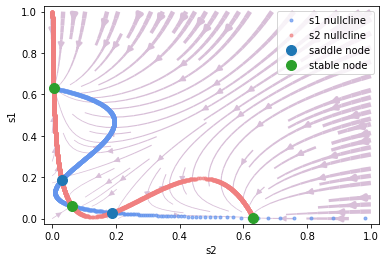

In [5]:
phase = bp.analysis.symbolic.PhasePlane(
  dm,
  target_vars=dict(s2=[0., 1.], s1=[0., 1.]),
  pars_update=dict(mu0=0., coh=0., Ib1=0.3297, Ib2=0.3297),
  numerical_resolution=0.0005,
  options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
_ = phase.plot_vector_field(show=True)

$\mu_0 = 30, c'=0.$

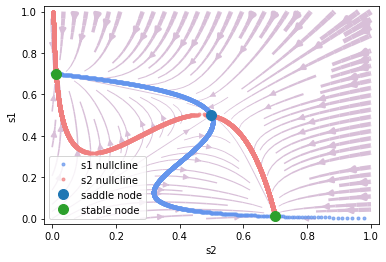

In [6]:
phase = bp.analysis.symbolic.PhasePlane(
  dm,
  target_vars=dict(s2=[0., 1.], s1=[0., 1.]),
  pars_update=dict(mu0=30., coh=0., Ib1=0.3297, Ib2=0.3297),
  numerical_resolution=0.0003,
  options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
_ = phase.plot_vector_field(show=True)

$\mu_0 = 30, c'=0.5$

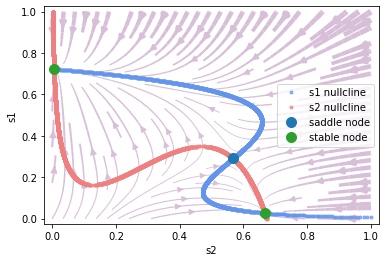

In [7]:
phase = bp.analysis.symbolic.PhasePlane(
  dm,
  target_vars=dict(s2=[0., 1.], s1=[0., 1.]),
  pars_update=dict(mu0=30., coh=0.5, Ib1=0.3297, Ib2=0.3297),
  numerical_resolution=0.0003,
  options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
_ = phase.plot_vector_field(show=True)

$\mu_0 = 30, c'=-0.5$

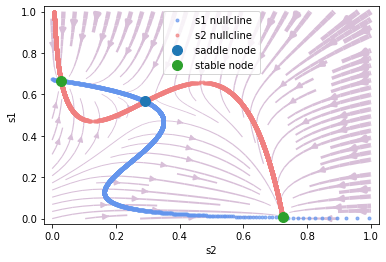

In [8]:
phase = bp.analysis.symbolic.PhasePlane(
  dm,
  target_vars=dict(s2=[0., 1.], s1=[0., 1.]),
  pars_update=dict(mu0=30., coh=-0.5, Ib1=0.3297, Ib2=0.3297),
  numerical_resolution=0.0003,
  options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
_ = phase.plot_vector_field(show=True)

$\mu_0 = 30, c'=1.$

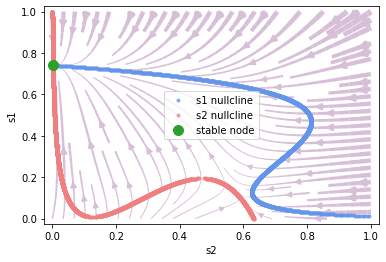

In [9]:
phase = bp.analysis.symbolic.PhasePlane(
  dm,
  target_vars=dict(s2=[0., 1.], s1=[0., 1.]),
  pars_update=dict(mu0=30., coh=1., Ib1=0.3297, Ib2=0.3297),
  numerical_resolution=0.0003,
  options={'escape_sympy_solver': True})

phase.plot_nullcline()
phase.plot_fixed_point()
_ = phase.plot_vector_field(show=True)